/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_89338/1847598363.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "Clear events": grp.apply(lambda g: g.loc[g[COL_CLEAR_ENG], COL_EVENT_ID].nunique()).values,
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_89338/1847598363.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "Clear events": grp.apply(lambda g: g.loc[g[COL_CLEAR_ENG],

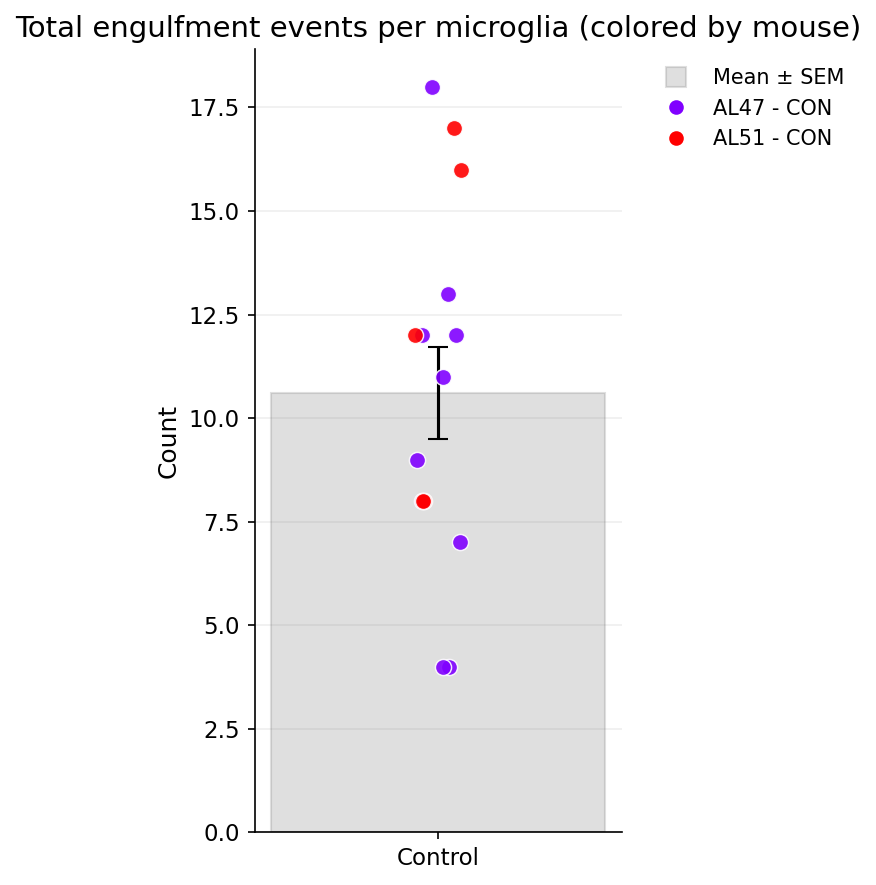

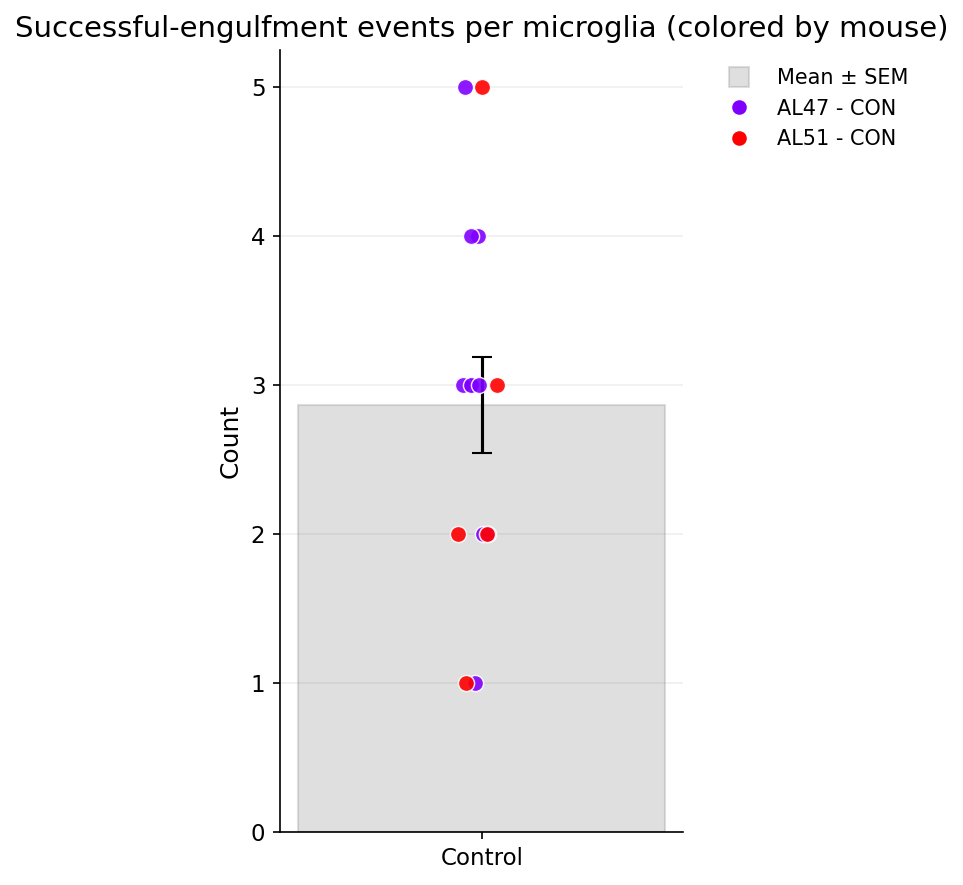

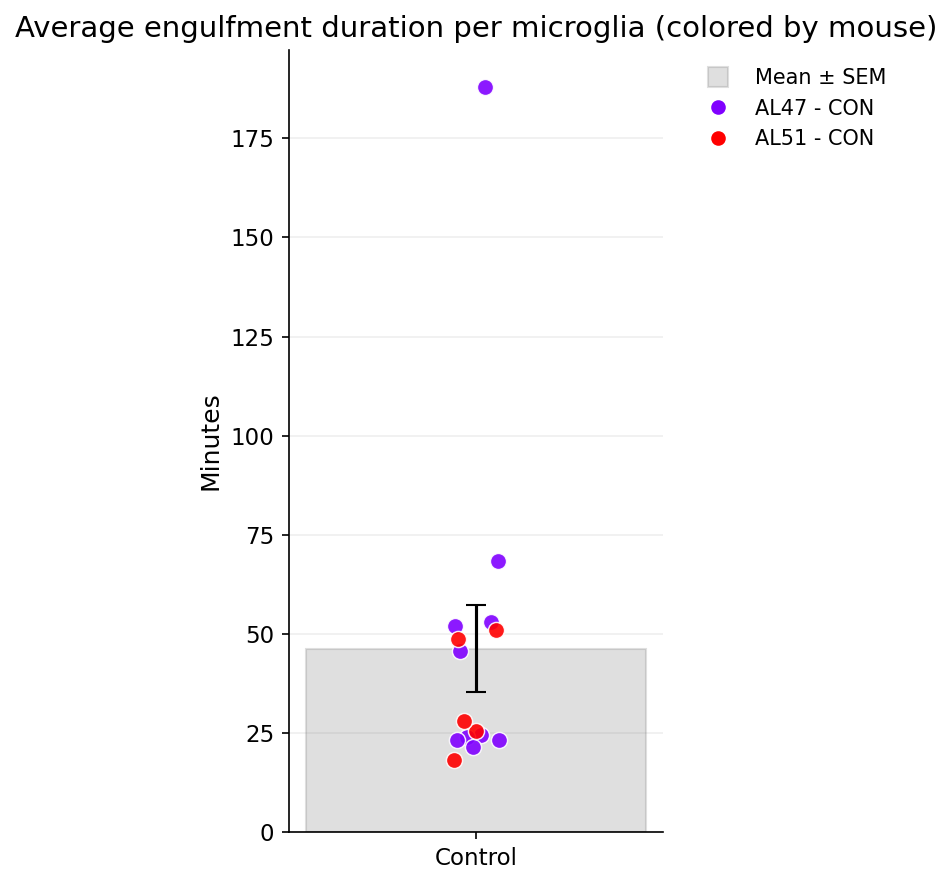

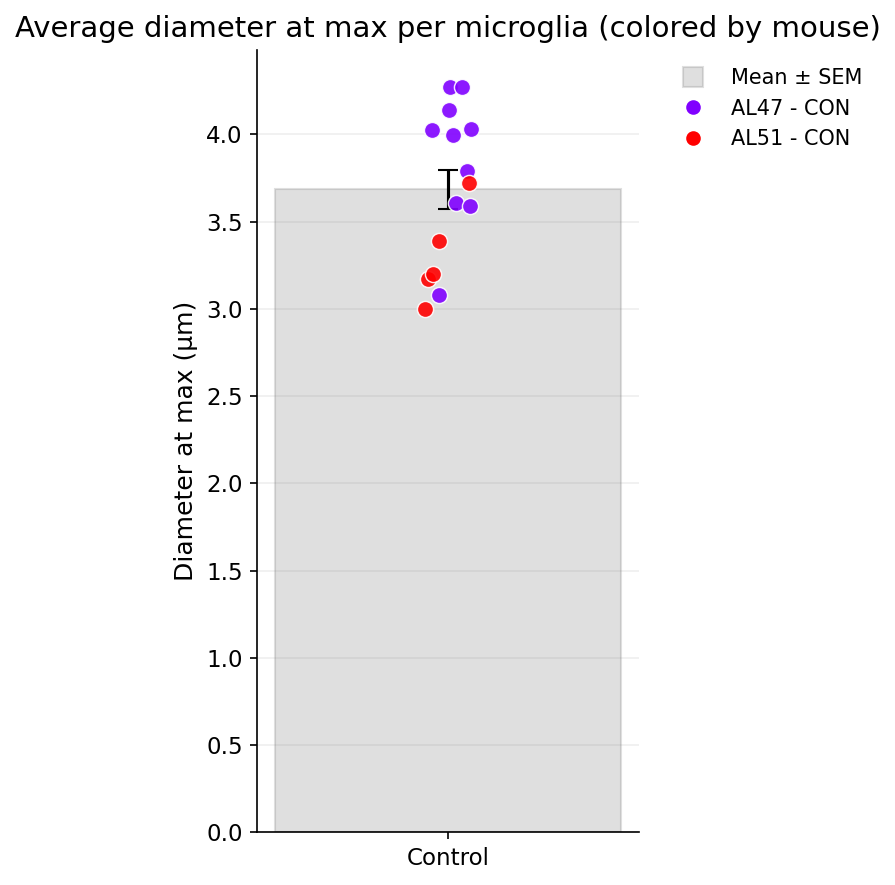

In [22]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === User-defined parameters ===
# Provide a list of (mouse_name, csv_path). Order controls rainbow order & legend order.
MICE = [
    ("AL47 - CON", "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/al47.csv"),
    ("AL51 - CON", "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/al51.csv"),
    # ("AL52 - COLD", "/path/to/al52.csv"),
]
TIME_PER_FRAME     = 8.0     # minutes per frame
INCLUSIVE_FRAMES   = False   # 10-11 -> 1 frame => exclusive
XTICK_LABEL        = "Control"   # text under the single bar
SAVE_PATH_BASE     = None    # e.g., "/path/to/output.png" (suffixes appended) or None to display
SAVE_DPI           = 450     # higher-DPI export

# CSV columns
COL_CELL_ID        = "Cell ID"
COL_EVENT_ID       = "Event ID"
COL_FRAME_START    = "Frame Start"
COL_FRAME_END      = "Frame End"
COL_SIZE_MAX       = "Size at max"
COL_CLEAR_ENG      = "Clear engulfment"

# ---- Style tweaks (no seaborn) ----
plt.rcParams.update({
    "figure.figsize": (5, 6),
    "figure.dpi": 150,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
})

# make jitter reproducible (optional)
np.random.seed(42)

def normalize_clear_flag(s: pd.Series) -> pd.Series:
    if s.dtype == bool: return s
    mapping = {
        "true": True, "t": True, "yes": True, "y": True, "1": True, "clear": True,
        "false": False, "f": False, "no": False, "n": False, "0": False, "unclear": False
    }
    def to_bool(x):
        if pd.isna(x): return False
        if isinstance(x, (int, float, np.integer, np.floating)): return bool(int(x))
        return mapping.get(str(x).strip().lower(), False)
    return s.apply(to_bool)

def duration_minutes(df: pd.DataFrame, inclusive: bool, minutes_per_frame: float) -> pd.Series:
    frames = df[COL_FRAME_END].astype(float) - df[COL_FRAME_START].astype(float)
    if inclusive:
        frames = frames + 1.0
    frames = frames.where(frames >= 0, np.nan)
    return frames * minutes_per_frame

def per_cell_metrics_for_mouse(mouse_name: str, csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    required = [COL_CELL_ID, COL_EVENT_ID, COL_FRAME_START, COL_FRAME_END, COL_SIZE_MAX, COL_CLEAR_ENG]
    missing  = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"[{mouse_name}] Missing required columns: {missing}. Found: {list(df.columns)}")

    df = df.copy()
    df[COL_CLEAR_ENG] = normalize_clear_flag(df[COL_CLEAR_ENG])
    df["Duration (min)"] = duration_minutes(df, INCLUSIVE_FRAMES, TIME_PER_FRAME)
    df[COL_SIZE_MAX] = pd.to_numeric(df[COL_SIZE_MAX], errors="coerce")

    grp = df.groupby(COL_CELL_ID, dropna=False)

    per_cell = pd.DataFrame({
        "Mouse": mouse_name,
        "Cell": grp.size().index.astype(str),
        "Total events": grp[COL_EVENT_ID].nunique().values,
        "Clear events": grp.apply(lambda g: g.loc[g[COL_CLEAR_ENG], COL_EVENT_ID].nunique()).values,
        "Average duration (min)": grp["Duration (min)"].mean().values,
        "Average size at max": grp[COL_SIZE_MAX].mean().values
    })
    return per_cell

# ---- Small helpers to prettify axes & annotate ----
def _prettify_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.yaxis.grid(True, linestyle="-", alpha=0.2)
    ax.set_axisbelow(True)

def _annotate_mean_sem(ax, x, mean, sem):
    if np.isfinite(mean):
        txt = f"Mean ± SEM\n{mean:.2f}"
        if np.isfinite(sem):
            txt += f" ± {sem:.2f}"
        ax.text(x, mean, txt, ha="center", va="bottom", fontsize=10)

def one_bar_with_jitter_multi_mouse(per_cell_df: pd.DataFrame, value_col: str,
                                    xtick_label: str, y_label: str, title: str,
                                    mouse_colors: dict, save_suffix: str = None):
    # summary stats
    vals = per_cell_df[value_col].astype(float).dropna()
    overall_mean = vals.mean()
    overall_sem  = vals.std(ddof=1) / np.sqrt(len(vals)) if len(vals) > 1 else np.nan

    fig, ax = plt.subplots()
    _prettify_axes(ax)

    bar_center = 1.0
    bar_width  = 0.32

    # mean ± SEM bar (soft fill + outline)
    ax.bar(
        bar_center, overall_mean,
        width=bar_width,
        yerr=overall_sem if np.isfinite(overall_sem) else None,
        capsize=5,
        alpha=0.25,
        color="grey",
        edgecolor="grey",
        linewidth=1.0,
        label="Mean ± SEM"
    )

    # jittered points by mouse (tidier appearance)
    # narrow jitter; add white edge for contrast
    jitter = np.random.uniform(-bar_width/14, bar_width/14, size=len(per_cell_df))
    x_positions = bar_center + jitter

    for (x, (_, row)) in zip(x_positions, per_cell_df.iterrows()):
        v = row[value_col]
        if pd.isna(v):
            continue
        ax.scatter(
            x, v,
            s=60,
            alpha=0.9,
            color=mouse_colors[row["Mouse"]],
            edgecolor="white",
            linewidth=0.7,
            zorder=3
        )

    ax.set_xticks([bar_center])
    ax.set_xticklabels([xtick_label])
    ax.set_ylabel(y_label)
    ax.set_title(title)

    # legend: mice in given order
    handles = [
        plt.Line2D([0],[0], marker="s", color="grey", label="Mean ± SEM",
                   alpha=0.25, markersize=10, linestyle="None")
    ] + [
        plt.Line2D([0],[0], marker="o", color=mouse_colors[mn], label=mn,
                   markersize=6, linestyle="None") for mn in mouse_colors.keys()
    ]
    leg = ax.legend(handles=handles, bbox_to_anchor=(1.04, 1), loc="upper left", frameon=False)
    fig.tight_layout()

    # save or show
    if SAVE_PATH_BASE:
        base, ext = os.path.splitext(SAVE_PATH_BASE)
        ext = ext if ext else ".png"
        out = f"{base}_{save_suffix}{ext}" if save_suffix else f"{base}{ext}"
        fig.savefig(out, dpi=SAVE_DPI, bbox_inches="tight")
        print(f"Saved: {out}")
    else:
        plt.show()

def plot_phagocytosis_metrics_multi():
    # load & concatenate per-cell summaries for all mice
    per_mouse_cells = [per_cell_metrics_for_mouse(name, path) for name, path in MICE]
    per_cell_all = pd.concat(per_mouse_cells, ignore_index=True)

    # Colorblind-friendly, discrete palette for mice
   # mouse_names = [name for name, _ in MICE]
  #  cmap = plt.cm.get_cmap('Set2', len(mouse_names))  # options: 'Dark2', 'tab10', etc.
  #  mouse_colors = {mn: cmap(i) for i, mn in enumerate(mouse_names)}


    # rainbow colors across mice (order as given in MICE)
    mouse_names = [name for name, _ in MICE]
    cmap = plt.cm.get_cmap('rainbow', len(mouse_names))
    mouse_colors = {mn: cmap(i) for i, mn in enumerate(mouse_names)}

    # plots (each point is a cell; color = mouse)
    one_bar_with_jitter_multi_mouse(
        per_cell_all, "Total events", XTICK_LABEL, "Count",
        "Total engulfment events per microglia (colored by mouse)",
        mouse_colors, save_suffix="total_events"
    )

    one_bar_with_jitter_multi_mouse(
        per_cell_all, "Clear events", XTICK_LABEL, "Count",
        "Successful-engulfment events per microglia (colored by mouse)",
        mouse_colors, save_suffix="clear_events"
    )

    one_bar_with_jitter_multi_mouse(
        per_cell_all, "Average duration (min)", XTICK_LABEL, "Minutes",
        "Average engulfment duration per microglia (colored by mouse)",
        mouse_colors, save_suffix="avg_duration"
    )

    # ⚠️ If 'Size at max' is an AREA, change units to 'µm²'
    one_bar_with_jitter_multi_mouse(
        per_cell_all, "Average size at max", XTICK_LABEL, "Diameter at max (µm)",
        "Average diameter at max per microglia (colored by mouse)",
        mouse_colors, save_suffix="avg_size"
    )

if __name__ == "__main__":
    plot_phagocytosis_metrics_multi()


/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_26759/2736014317.py:145: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "Clear events": grp.apply(lambda g: g.loc[g[COL_CLEAR_ENG], COL_EVENT_ID].nunique()).values,
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_26759/2736014317.py:145: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "Clear events": grp.apply(lambda g: g.loc[g[COL_CLEAR_ENG

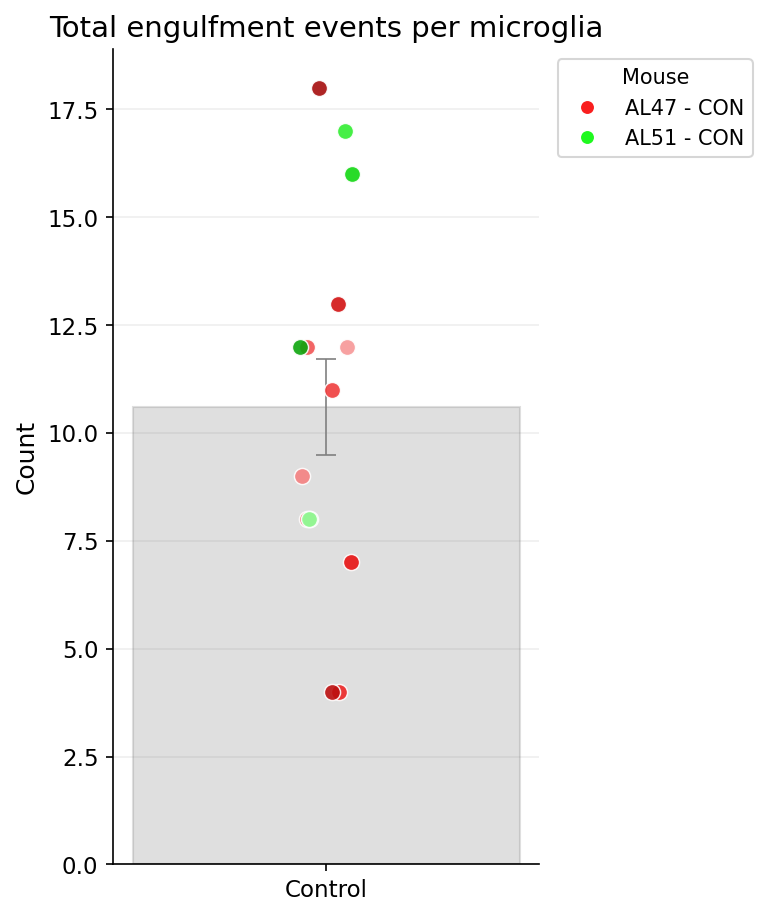

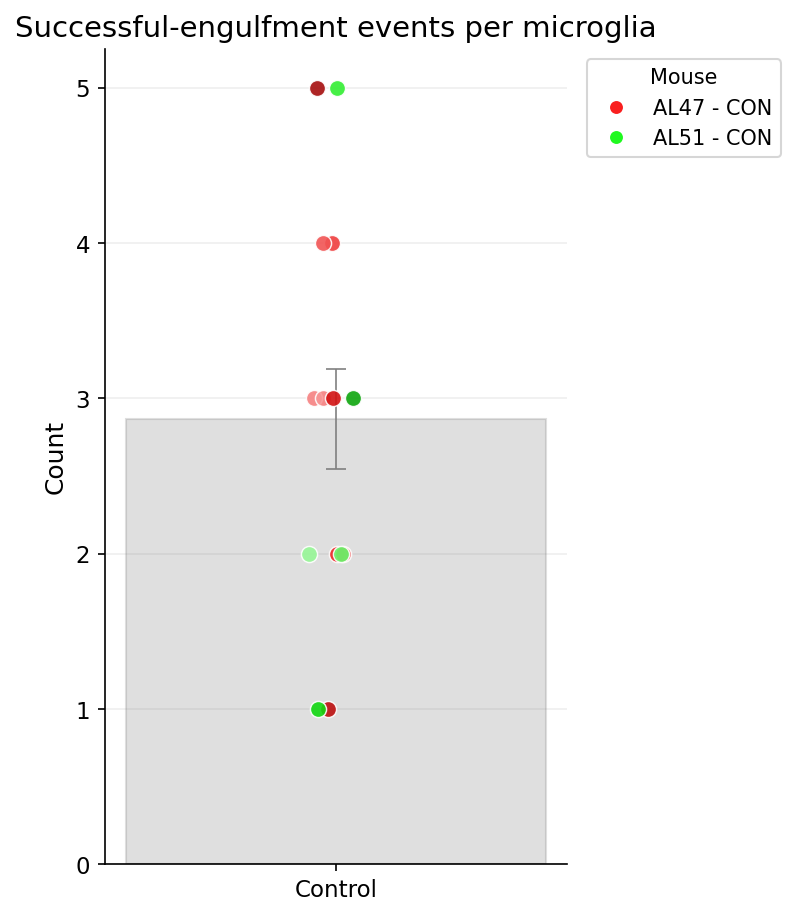

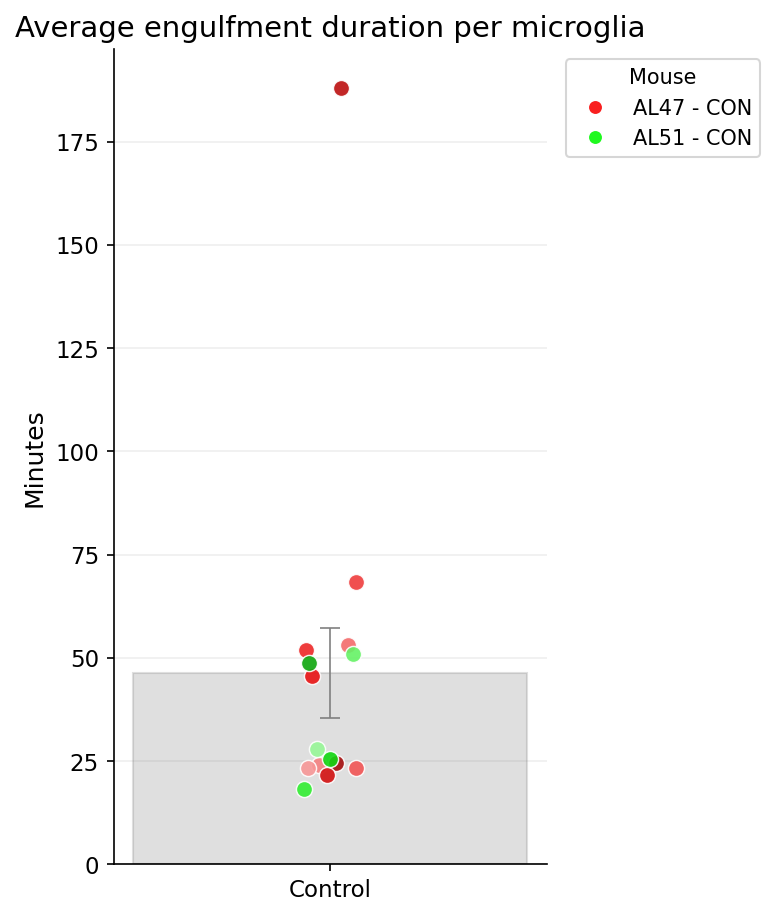

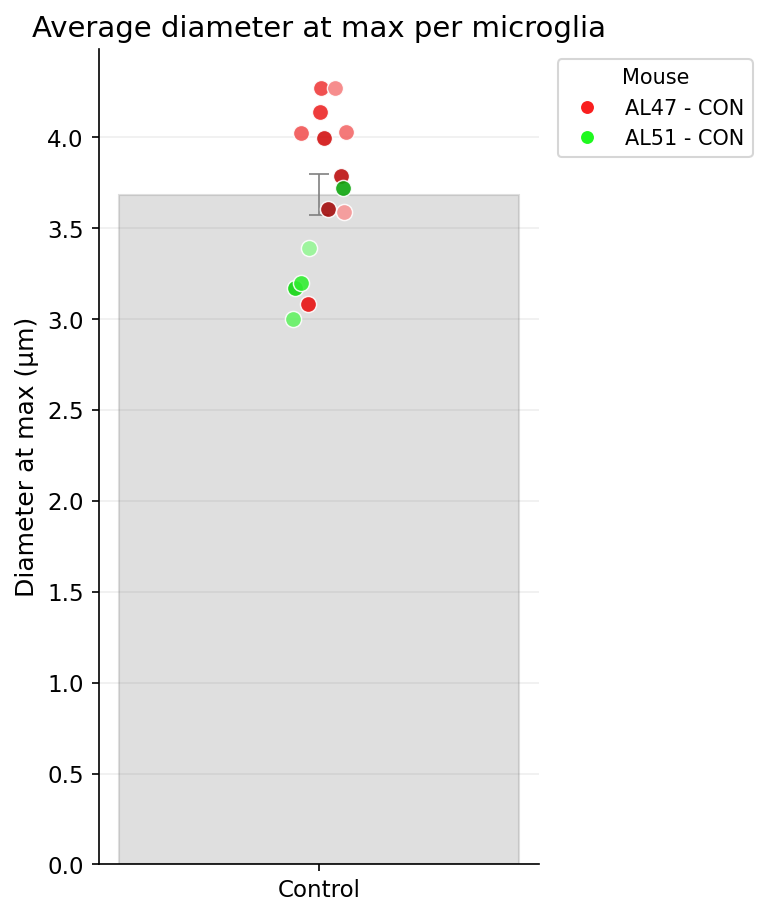

In [4]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import colorsys

# === User-defined parameters ===
MICE = [
    ("AL47 - CON", "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/al47.csv"),
    ("AL51 - CON", "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/al51.csv"),
    # ("AL52 - COLD", "/path/to/al52.csv"),
]
TIME_PER_FRAME     = 8.0     # minutes per frame
INCLUSIVE_FRAMES   = False   # 10-11 -> 1 frame => exclusive
XTICK_LABEL        = "Control"
SAVE_PATH_BASE     = None    # e.g., "/path/to/output.png" (suffixes appended) or None to display
SAVE_DPI           = 450

# CSV columns
COL_CELL_ID        = "Cell ID"
COL_EVENT_ID       = "Event ID"
COL_FRAME_START    = "Frame Start"
COL_FRAME_END      = "Frame End"
COL_SIZE_MAX       = "Size at max"
COL_CLEAR_ENG      = "Clear engulfment"

# ---- Style tweaks (no seaborn) ----
plt.rcParams.update({
    "figure.figsize": (5, 6),
    "figure.dpi": 150,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
})

np.random.seed(42)  # reproducible jitter

# ===================== Color helpers =====================
def _very_distinct_mouse_colors(mouse_names, light=0.55, sat=0.95):
    """
    Fixed, human-friendly hue order; if >10 mice, append evenly spaced hues.
    Returns dict: mouse -> RGBA.
    """
    H_BASE = [0.00, 1/3, 2/3, 5/6, 1/6, 0.50, 0.75, 1/12, 7/12, 11/12]
    if len(mouse_names) <= len(H_BASE):
        hues = H_BASE[:len(mouse_names)]
    else:
        hues = H_BASE + list(np.linspace(0, 1, len(mouse_names) - len(H_BASE), endpoint=False))
    out = {}
    for m, h in zip(mouse_names, hues):
        r, g, b = colorsys.hls_to_rgb(h, light, sat)  # colorsys uses HLS
        out[m] = (r, g, b, 1.0)
    return out

def _rgb_to_hls(rgb):
    r, g, b = rgb[:3]
    return colorsys.rgb_to_hls(r, g, b)

def _hls_to_rgb(h, l, s):
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b, 1.0)

def _microglia_shades_by_mouse(per_cell_df: pd.DataFrame, mouse_colors: dict,
                               cell_col="Cell", light_min=0.35, light_max=0.78, sat=0.85):
    """
    For each mouse, vary lightness along that mouse's hue to give each cell a unique shade.
    Returns dict keyed by (mouse, cell_str) -> RGBA.
    """
    shades = {}
    for mouse, base_rgb in mouse_colors.items():
        h_base, _, _ = _rgb_to_hls(base_rgb)
        gids = sorted(per_cell_df.loc[per_cell_df["Mouse"] == mouse, cell_col].astype(str).unique())
        k = len(gids)
        if k <= 1:
            Ls = [0.55] if k == 1 else []
        else:
            Ls = np.linspace(light_min, light_max, k)
        for L, gid in zip(Ls, gids):
            shades[(mouse, gid)] = _hls_to_rgb(h_base, float(L), float(sat))
    return shades

def _legend_outside(ax, mouse_colors: dict, title="Mouse", include_mean=False):
    """
    Single legend with one entry per mouse (base color only) plus optional Mean±SEM swatch.
    Placed outside on the right; relies on layout='constrained' on the figure.
    """
    handles = []
    if include_mean:
        handles.append(
            plt.Line2D([0],[0], marker="s", linestyle="None",
                       markerfacecolor=(0.5,0.5,0.5,0.25),
                       markeredgecolor="grey", markeredgewidth=1.0,
                       label="Mean ± SEM", markersize=10)
        )
    for m in mouse_colors.keys():  # preserve given order
        handles.append(
            plt.Line2D([0],[0], marker="o", linestyle="None",
                       markerfacecolor=mouse_colors[m],
                       markeredgecolor="white", markeredgewidth=0.8,
                       label=str(m), markersize=7)
        )
    ax.legend(handles=handles, title=title,
              bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)

# ===================== Data wrangling =====================
def normalize_clear_flag(s: pd.Series) -> pd.Series:
    if s.dtype == bool: return s
    mapping = {
        "true": True, "t": True, "yes": True, "y": True, "1": True, "clear": True,
        "false": False, "f": False, "no": False, "n": False, "0": False, "unclear": False
    }
    def to_bool(x):
        if pd.isna(x): return False
        if isinstance(x, (int, float, np.integer, np.floating)): return bool(int(x))
        return mapping.get(str(x).strip().lower(), False)
    return s.apply(to_bool)

def duration_minutes(df: pd.DataFrame, inclusive: bool, minutes_per_frame: float) -> pd.Series:
    frames = df[COL_FRAME_END].astype(float) - df[COL_FRAME_START].astype(float)
    if inclusive:
        frames = frames + 1.0
    frames = frames.where(frames >= 0, np.nan)
    return frames * minutes_per_frame

def per_cell_metrics_for_mouse(mouse_name: str, csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    required = [COL_CELL_ID, COL_EVENT_ID, COL_FRAME_START, COL_FRAME_END, COL_SIZE_MAX, COL_CLEAR_ENG]
    missing  = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"[{mouse_name}] Missing required columns: {missing}. Found: {list(df.columns)}")

    df = df.copy()
    df[COL_CLEAR_ENG] = normalize_clear_flag(df[COL_CLEAR_ENG])
    df["Duration (min)"] = duration_minutes(df, INCLUSIVE_FRAMES, TIME_PER_FRAME)
    df[COL_SIZE_MAX] = pd.to_numeric(df[COL_SIZE_MAX], errors="coerce")

    grp = df.groupby(COL_CELL_ID, dropna=False)
    per_cell = pd.DataFrame({
        "Mouse": mouse_name,
        "Cell": grp.size().index.astype(str),
        "Total events": grp[COL_EVENT_ID].nunique().values,
        "Clear events": grp.apply(lambda g: g.loc[g[COL_CLEAR_ENG], COL_EVENT_ID].nunique()).values,
        "Average duration (min)": grp["Duration (min)"].mean().values,
        "Average size at max": grp[COL_SIZE_MAX].mean().values
    })
    return per_cell

# ---- Small helpers to prettify axes & annotate ----
def _prettify_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.yaxis.grid(True, linestyle="-", alpha=0.2)
    ax.set_axisbelow(True)

def _annotate_mean_sem(ax, x, mean, sem):
    if np.isfinite(mean):
        txt = f"Mean ± SEM\n{mean:.2f}"
        if np.isfinite(sem):
            txt += f" ± {sem:.2f}"
        ax.text(x, mean, txt, ha="center", va="bottom", fontsize=10)

# ===================== Plotting =====================
def one_bar_with_jitter_multi_mouse(per_cell_df: pd.DataFrame, value_col: str,
                                    xtick_label: str, y_label: str, title: str,
                                    mouse_colors: dict, microglia_shades: dict,
                                    save_suffix: str = None):
    # summary stats
    vals = per_cell_df[value_col].astype(float).dropna()
    overall_mean = vals.mean()
    overall_sem  = vals.std(ddof=1) / np.sqrt(len(vals)) if len(vals) > 1 else np.nan

    # Constrained layout so outside legend never clips
    fig, ax = plt.subplots(layout="constrained")
    _prettify_axes(ax)

    bar_center = 1.0
    bar_width  = 0.32

    # mean ± SEM bar (soft fill + outline, skinny errorbars)
    ERROR_KW = dict(ecolor="grey", elinewidth=0.8, capsize=5, capthick=0.8)
    ax.bar(
        bar_center, overall_mean,
        width=bar_width,
        yerr=overall_sem if np.isfinite(overall_sem) else None,
        error_kw=ERROR_KW,
        alpha=0.25, color="grey",
        edgecolor="grey", linewidth=1.0,
        label="Mean ± SEM", zorder=1
    )

    # jittered points; color by (Mouse, Cell) shade; outlined
    jitter = np.random.uniform(-bar_width/14, bar_width/14, size=len(per_cell_df))
    for (x, (_, row)) in zip(bar_center + jitter, per_cell_df.iterrows()):
        v = row[value_col]
        if pd.isna(v):
            continue
        m = row["Mouse"]; cid = str(row["Cell"])
        color = microglia_shades.get((m, cid), mouse_colors[m])
        ax.scatter(
            x, v,
            s=60, alpha=0.9,
            color=color,
            edgecolor="white", linewidth=0.7,
            zorder=3
        )

    ax.set_xticks([bar_center])
    ax.set_xticklabels([xtick_label])
    ax.set_ylabel(y_label)
    ax.set_title(title)

    # Legend outside: one entry per mouse (base color only) + Mean±SEM swatch
    _legend_outside(ax, mouse_colors, title="Mouse")

    # save or show
    if SAVE_PATH_BASE:
        base, ext = os.path.splitext(SAVE_PATH_BASE)
        ext = ext if ext else ".png"
        out = f"{base}_{save_suffix}{ext}" if save_suffix else f"{base}{ext}"
        fig.savefig(out, dpi=SAVE_DPI, bbox_inches="tight")
        print(f"Saved: {out}")
    else:
        plt.show()

def plot_phagocytosis_metrics_multi():
    # load & concatenate per-cell summaries for all mice
    per_mouse_cells = [per_cell_metrics_for_mouse(name, path) for name, path in MICE]
    per_cell_all = pd.concat(per_mouse_cells, ignore_index=True)

    # Base colors per mouse (order as given in MICE)
    mouse_names = [name for name, _ in MICE]
    mouse_colors = _very_distinct_mouse_colors(mouse_names)

    # Shades per microglia within each mouse
    microglia_shades = _microglia_shades_by_mouse(per_cell_all, mouse_colors, cell_col="Cell")

    # plots (each point is a cell; color = shade within mouse hue)
    one_bar_with_jitter_multi_mouse(
        per_cell_all, "Total events", XTICK_LABEL, "Count",
        "Total engulfment events per microglia",
        mouse_colors, microglia_shades, save_suffix="total_events"
    )

    one_bar_with_jitter_multi_mouse(
        per_cell_all, "Clear events", XTICK_LABEL, "Count",
        "Successful-engulfment events per microglia",
        mouse_colors, microglia_shades, save_suffix="clear_events"
    )

    one_bar_with_jitter_multi_mouse(
        per_cell_all, "Average duration (min)", XTICK_LABEL, "Minutes",
        "Average engulfment duration per microglia",
        mouse_colors, microglia_shades, save_suffix="avg_duration"
    )

    # ⚠️ If 'Size at max' is an AREA, change units to 'µm²'
    one_bar_with_jitter_multi_mouse(
        per_cell_all, "Average size at max", XTICK_LABEL, "Diameter at max (µm)",
        "Average diameter at max per microglia",
        mouse_colors, microglia_shades, save_suffix="avg_size"
    )

if __name__ == "__main__":
    plot_phagocytosis_metrics_multi()
